## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/wind.csv")
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
0,0,25.896492,-97.460358,Texas,onshore,7.46,31,2,0.433,1.997163,17495.14630,7575.398348,4.696747e+06
1,1,26.032654,-97.738098,Texas,onshore,7.45,31,10,0.414,9.945710,87124.42376,36069.511440,2.236310e+07
2,2,26.059063,-97.208252,Texas,onshore,8.18,31,2,0.506,2.633037,23065.40088,11671.092850,7.236078e+06
3,3,26.078449,-98.073364,Texas,onshore,7.17,31,16,0.363,14.185493,124264.92160,45108.166540,2.796706e+07
4,4,26.143227,-98.311340,Texas,onshore,7.06,31,16,0.358,13.542570,118632.91080,42470.582050,2.633176e+07


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
70816,70816,42.770447,-105.846069,Wyoming,onshore,9.52,30,12,0.429,24.903425,218154.00560,93588.068410,5.615284e+07
45705,45705,40.527233,-86.395111,Indiana,onshore,7.38,37,16,0.445,15.468780,135506.51270,60300.398130,4.462229e+07
60161,60161,41.261482,-82.054718,Ohio,onshore,6.94,39,10,0.369,8.039803,70428.67401,25988.180710,2.027078e+07
66924,66924,42.571953,-88.600952,Wisconsin,onshore,7.65,33,16,0.420,17.229445,150929.93620,63390.573220,4.183778e+07
87265,87265,43.272633,-112.698792,Idaho,onshore,5.89,44,6,0.306,2.948928,25832.60690,7904.777711,6.956204e+06


Looking at each dataset, we can identify which variables we want to use for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y_energy = df['generated_energy'].values
y_cost = df['cost'].values

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [5]:
X_train = X[:100000]
X_test = X[100000:]
y_energy_train = y_energy[:100000]
y_energy_test = y_energy[100000:]
y_cost_train = y_cost[:100000]
y_cost_test = y_cost[100000:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [6]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 5.12792434e-01, -5.97749762e-01, -6.74179171e-01],
       [-5.40909232e-04,  1.04045828e+00,  5.14335794e-01],
       [ 1.67483405e-01,  1.40601696e+00, -1.26843665e+00],
       ...,
       [ 7.18263624e-01,  2.25951248e+00, -1.26843665e+00],
       [ 1.85068016e+00, -6.61101747e-01,  5.14335794e-01],
       [ 2.41293149e-01, -6.99414135e-01,  5.14335794e-01]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [7]:
energy_reg = svm.SVR()
cost_reg = svm.SVR()
energy_reg.fit(X_train, y_energy_train)
cost_reg.fit(X_train, y_cost_train)

SVR()

With a trained model, predictions can now be made.

In [10]:
#| label: prediction-comparisons

energy_display = y_energy_test
cost_display = y_cost_test
energy_preds = energy_reg.predict(X_test)
cost_preds = cost_reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {energy_preds[i]:.2f}\tactual energy: {energy_display[i]:.2f}\tpredicted cost: {cost_preds[i]:.2f}\tactual cost: {cost_display[i]:.2f}")

Predictions
----------------------
predicted energy: 57328.67	actual energy: 40842.41	predicted cost: 39489716.81	actual cost: 36758169.87
predicted energy: 49636.20	actual energy: 10659.56	predicted cost: 39480504.51	actual cost: 6822119.29
predicted energy: 50298.13	actual energy: 9386.53	predicted cost: 39481146.84	actual cost: 8823336.22


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [11]:
#| label: metrics

energy_r2 = metrics.r2_score(y_energy_test, energy_preds, multioutput="raw_values")
energy_rmse = metrics.root_mean_squared_error(y_energy_test, energy_preds, multioutput="raw_values")
energy_mape = metrics.mean_absolute_percentage_error(y_energy_test, energy_preds, multioutput="raw_values")

cost_r2 = metrics.r2_score(y_cost_test, cost_preds, multioutput="raw_values")
cost_rmse = metrics.root_mean_squared_error(y_cost_test, cost_preds, multioutput="raw_values")
cost_mape = metrics.mean_absolute_percentage_error(y_cost_test, cost_preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"energy_r2\t{energy_r2}\ncost_r2\t{cost_r2}\nenergy_rmse\t{energy_rmse}\ncost_rmse\t{cost_rmse}\nenergy_mape\t{energy_mape}\ncost_mape\t{cost_mape}")

Metric	Score
-----------------------
energy_r2	[0.123724]
cost_r2	[0.00020249]
energy_rmse	[29742.00648558]
cost_rmse	[19613745.35965985]
energy_mape	[1.08458669]
cost_mape	[0.98070773]


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [17]:
#| label: k-fold-cross-validation-table-energy

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(energy_reg, X, y_energy, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: 0.0018450300789964902
RMSE Average: 31730.72214388117
MAPE Average: 1.1974198375900589


,fit_time,score_time,test_r2,test_rmse,test_mape
0,771.961335,90.775717,0.002921,31909.960130,1.150887
1,771.080194,90.634640,0.002406,31278.957484,1.194819
2,758.963423,90.289549,0.003153,31580.604349,1.276420
3,740.477523,88.983850,0.001673,31700.498088,1.158536
4,736.539896,88.923703,0.001296,31842.196502,1.261852
5,737.672136,89.011240,0.000597,31694.965905,1.201443
6,736.014961,89.161244,0.002357,31440.657336,1.128294
7,738.921449,88.798775,0.002150,31583.352399,1.273676
8,738.560741,88.798225,0.000881,32331.064876,1.176411
9,737.216899,88.766471,0.001017,31944.964370,1.151860


In [18]:
#| label: k-fold-cross-validation-table-cost

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(cost_reg, X, y_cost, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: -0.00017107792075631288
RMSE Average: 19730288.835201103
MAPE Average: 0.9651219794341653


,fit_time,score_time,test_r2,test_rmse,test_mape
0,401.449423,88.838005,-0.000394,1.963845e+07,0.926044
1,401.821544,89.089334,-0.000016,1.952591e+07,0.965267
2,400.949044,88.836812,-0.000417,1.976890e+07,1.021886
3,401.101503,88.819128,-0.000002,1.964222e+07,0.946757
4,400.615725,88.751960,-0.000103,1.992799e+07,1.014057
5,401.312933,89.032375,-0.000370,1.971245e+07,0.962284
6,401.158882,88.770521,-0.000006,1.930747e+07,0.919042
7,400.537041,88.876982,0.000005,1.968026e+07,1.019527
8,400.704807,88.816629,-0.000183,2.014325e+07,0.954541
9,407.294723,88.969792,-0.000225,1.995599e+07,0.921815


##### Graphs

Graphs of the SVR model fits on each on the input features, for each target.

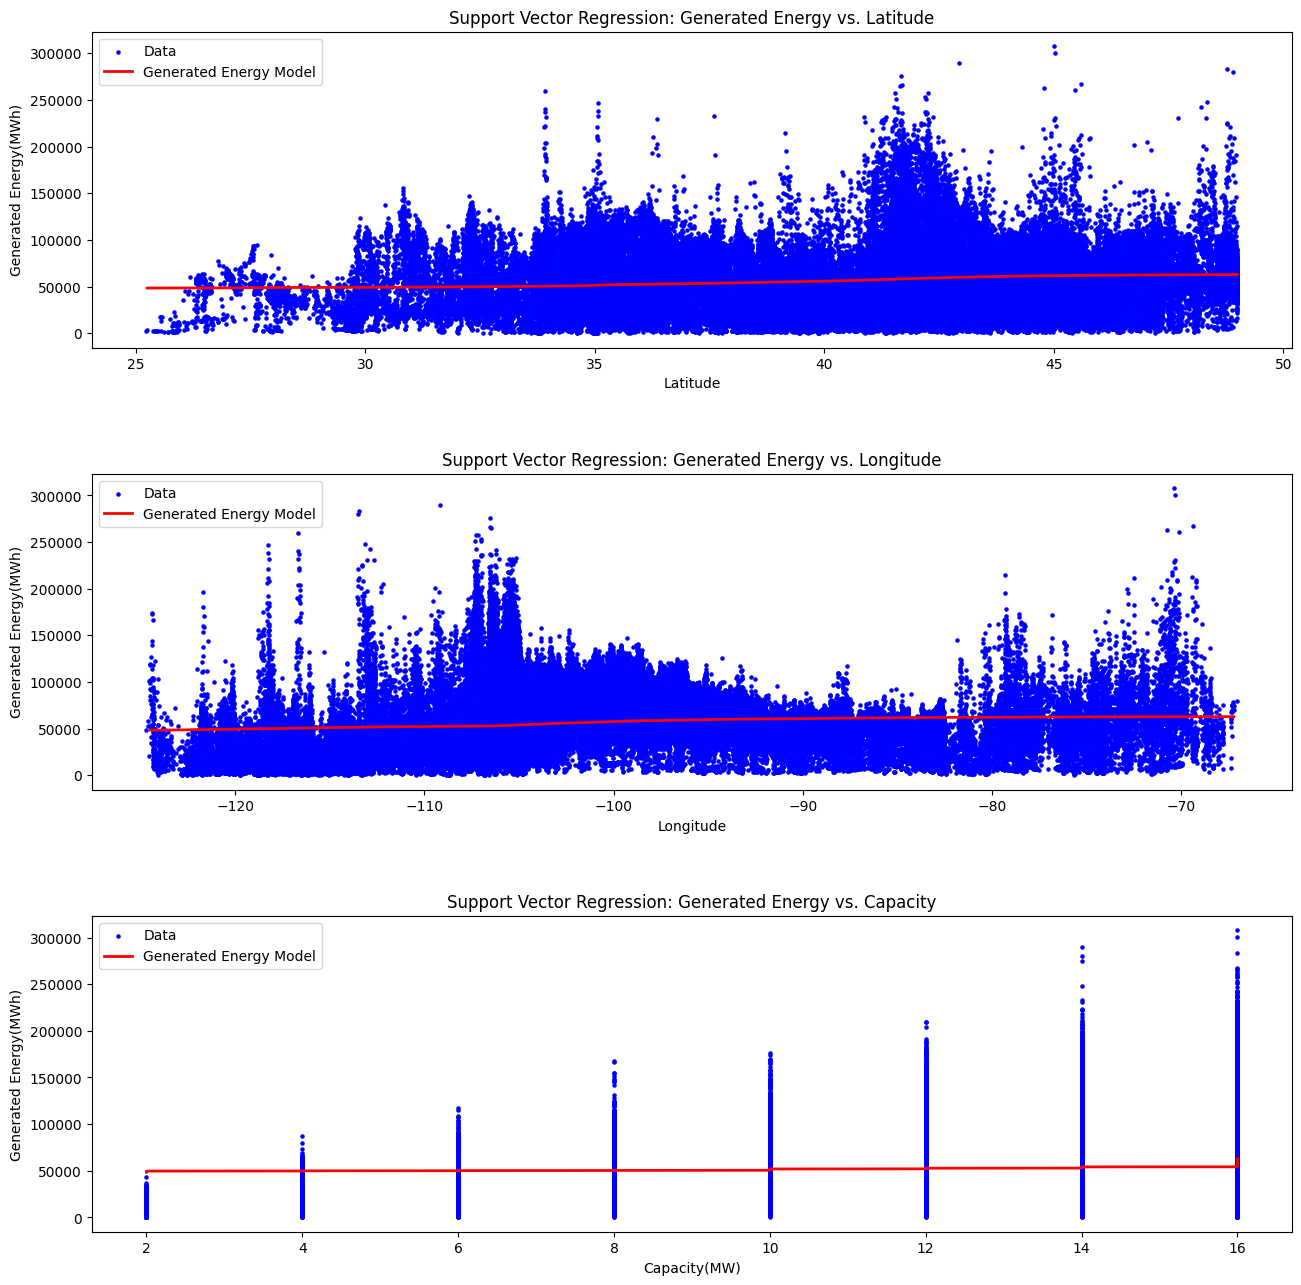

In [22]:
#| label: fig-generated-energy-vs-input-features

plot_lat_x = X[100000:].loc[:,['lat']].sort_values(by=['lat'])
plot_long_x = X[100000:].loc[:,['long']].sort_values(by=['long'])
plot_cap_x = X[100000:].loc[:,['capacity']].sort_values(by=['capacity'])
plot_energy_y = pd.DataFrame(energy_preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y_energy, color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Generated Energy(MWh)")
axis[0].set_title("Support Vector Regression: Generated Energy vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y_energy, color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Generated Energy(MWh)")
axis[1].set_title("Support Vector Regression: Generated Energy vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y_energy, color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Generated Energy(MWh)")
axis[2].set_title("Support Vector Regression: Generated Energy vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

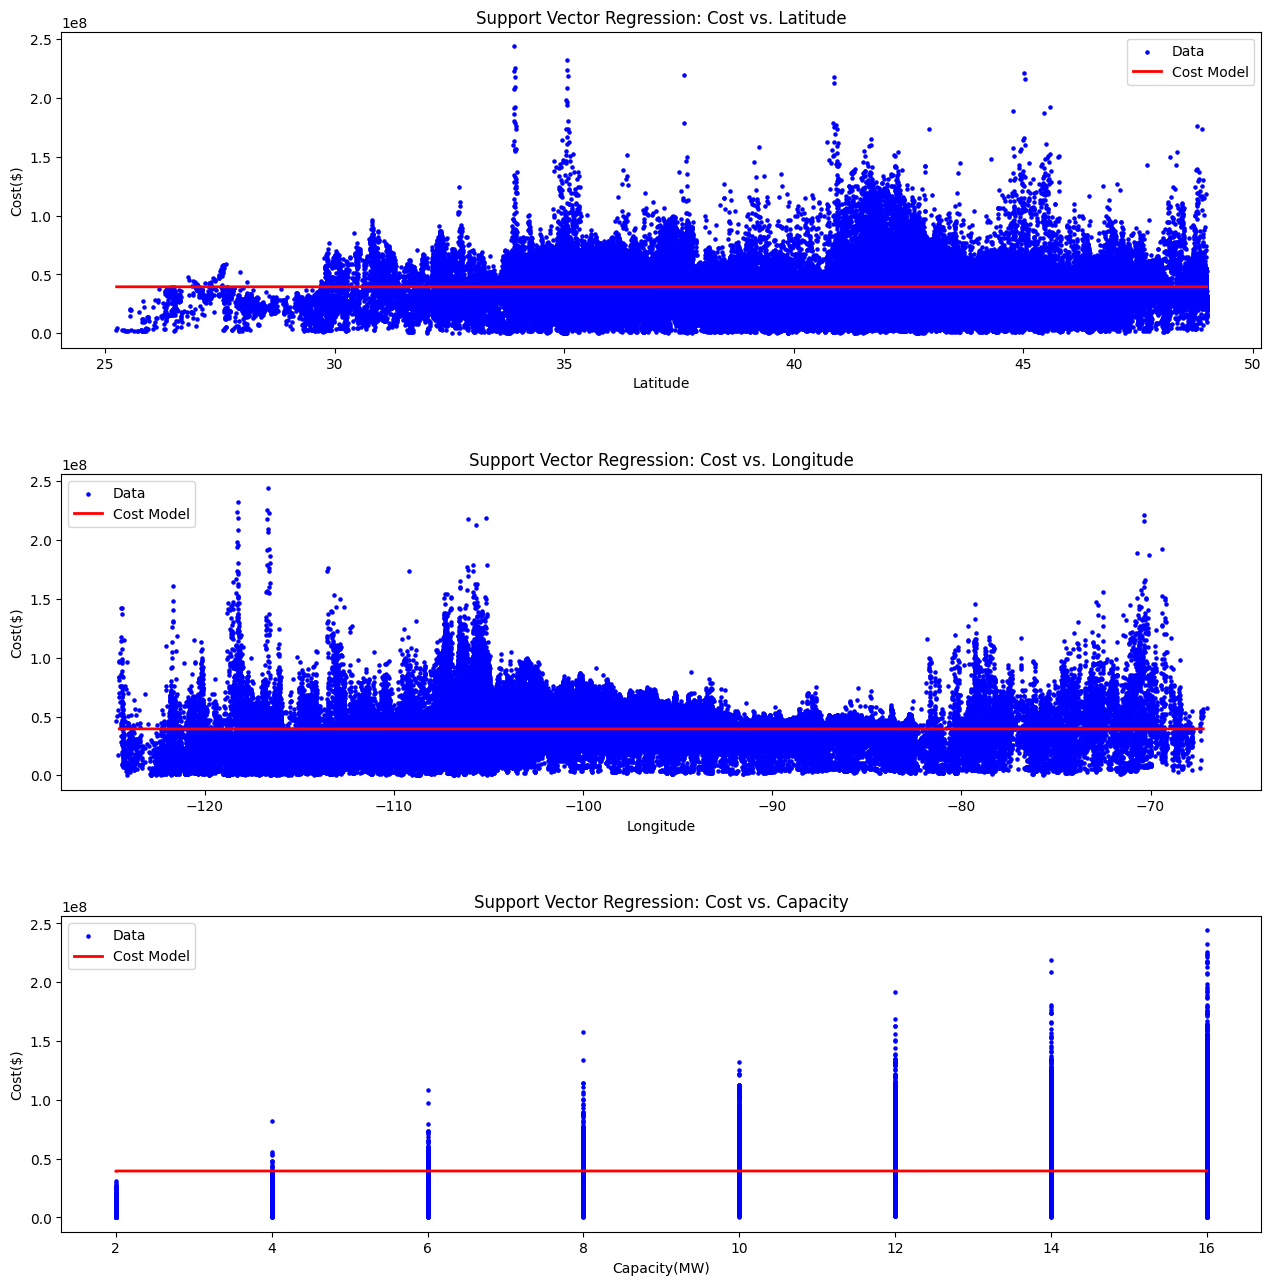

In [21]:
#| label: fig-cost-vs-input-features

plot_cost_y = pd.DataFrame(cost_preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y_cost, color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Cost($)")
axis[0].set_title("Support Vector Regression: Cost vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y_cost, color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Cost($)")
axis[1].set_title("Support Vector Regression: Cost vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y_cost, color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Cost($)")
axis[2].set_title("Support Vector Regression: Cost vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()